Goal:
- Allow the spatial model to include local vaccinations
    - From the data
    - From a prediction into the future (many scenarios possible, but keep it simple). This is included in the `__call__` function of the `make_vaccination_function`, 
- Allow the model to include local measures (no priority)
- Allow the model to include local spread of VOCs (no priority)
- Main question: what is the distribution of hospitalisations in Belgium and how is this linked to the degree of vaccination?
- Side questions
    - How does the increase in Brussels affect the rest of the country?
    - How can this be alleviated with local measures? How is this different from national measures?
    - How can this be alleviated with isolation of Brussels?
    - How would the situation have been if Brussels was vaccinated as the rest-of-the-country average? And if Belgium was vaccinated as Brussels? 

**Remarks**

- Why are the vaccine-eligible subjects only those from class S and R? Would make sense to also include E and A
- Why do subjects from R become dS_v?
- `dD_v = (m_ICU/dICU_D)*ICU_v + (m_C/dc_D)*C_v` seems incomplete, unless the chance of dying once a subject is hospitalised is the same with or without vaccination. Not sure if there is data available on this.
- Note: `N_vacc` must be age and space stratified. It is not yet obvious how this is implemented into the main model (we'd have to dig deep into the code). The same problem goes with `Nc` if we are to stratify this spatially (per province).
- What type of vaccination does `get_public_spatial_vaccination_data` return? First vaccination, I suppose?

In [1]:
# Preamble
import corner
import pandas as pd
import json
import numpy as np
from IPython.display import IFrame
import matplotlib.pyplot as plt

from covid19model.models import models
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_contact_matrix_function, make_VOC_function, make_vaccination_function
from covid19model.models.utils import initial_state
# from covid19model.optimization.run_optimization import checkplots, calculate_R0
# from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
# from covid19model.optimization import pso, objective_fcns
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot, plot_fit, plot_calibration_fit
from covid19model.visualization.utils import moving_avg
from covid19model.optimization.utils import perturbate_PSO, run_MCMC
from covid19model.optimization.utils import samples_dict_to_emcee_chain # used for corner plots
import random
import datetime

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

# Copied from mrollier-calibration-WAVE2_spatial.ipynb
import gc
import sys, getopt
import os
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool

from covid19model.models import models
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot
from covid19model.models.utils import initial_state


agg='prov'

In [2]:
# Total population and contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices(spatial=agg)

# Google Mobility data (for social contact Nc)
df_google = mobility.get_google_mobility_data(update=False)

# Load and format mobility dataframe (for mobility place)
proximus_mobility_data, proximus_mobility_data_avg = mobility.get_proximus_mobility_data(agg, dtype='fractional', beyond_borders=False)
# Converting the index as date. Probably not necessary because it's already done.
# all_mobility_data.index = pd.to_datetime(all_mobility_data.index)

# Load and format national VOC data (for time-dependent VOC fraction)
df_VOC_abc = VOC.get_abc_data()

# Load and format local vaccination data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

params = model_parameters.get_COVID19_SEIRD_parameters(spatial=agg, vaccination=True,VOC=True)


### TIME-DEPENDENT FUNCTIONS ###
# Define time-dependent social contact matrix
contact_matrix_function = make_contact_matrix_function(df_google, Nc_all)
ramp_fun = make_contact_matrix_function(df_google, Nc_all).ramp_fun
policies_WAVE2_no_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_no_relaxation

# Mobility update function from class __call__ and function wrapper to get the right signature
mobility_wrapper_function = make_mobility_update_function(proximus_mobility_data, proximus_mobility_data_avg).mobility_wrapper_func

# function to update VOC fraction
VOC_function = make_VOC_function(df_VOC_abc)

# function to update local vaccination level
public_spatial_vaccination_data = sciensano.get_public_spatial_vaccination_data(update=False,agg=agg)
public_spatial_vaccination_data

vaccination_function = make_vaccination_function(public_spatial_vaccination_data, spatial=True)
sciensano_spatial_first_dose = make_vaccination_function(public_spatial_vaccination_data, spatial=True).get_sciensano_spatial_first_dose

c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:264: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_start = pd.Timestamp(df['INCIDENCE'].ne(0).idxmax()[0], freq='D')
c:\users\mrollier\documents\github\covid19-model\src\covid19model\models\time_dependant_parameter_fncs.py:265: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  self.df_end = pd.Timestamp(df.index[-1][0], freq='D')


## Visualise raw vaccination data

Text(0, 0.5, 'First vaccination per age')

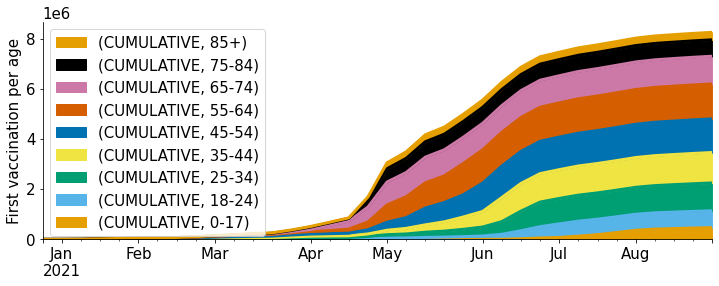

In [4]:
# Visualise vaccination data per age
fig, ax = plt.subplots(figsize=(12,4))
# public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week', 'age']).sum().plot(ax=ax)

df = public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week','age']).sum()
df.unstack().plot(kind='area', stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel('First vaccination per age')

Text(0, 0.5, 'First vaccination per province')

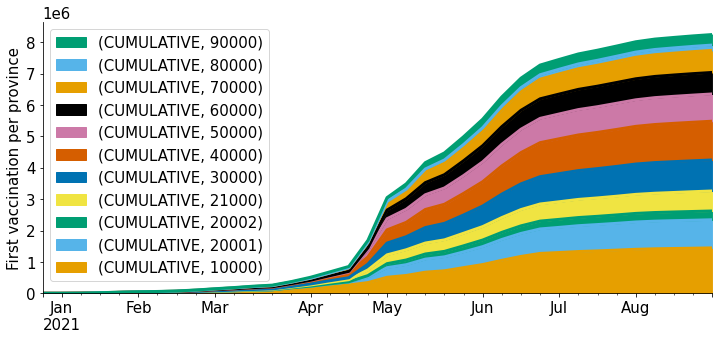

In [5]:
# Visualise vaccination data per province
fig, ax = plt.subplots(figsize=(12,5))
# public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week', 'age']).sum().plot(ax=ax)

df = public_spatial_vaccination_data[['CUMULATIVE']].groupby(['start_week','NIS']).sum()
df.unstack().plot(kind='area', stacked=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')
ax.grid(False)
ax.set_xlabel(None)
ax.set_ylabel('First vaccination per province')

## Visualise VOCs

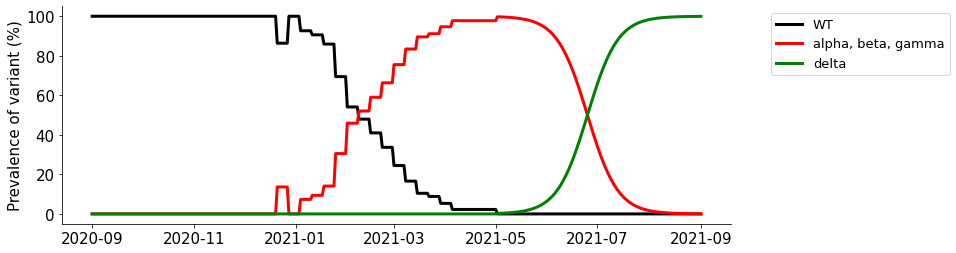

In [6]:
### EXTRA -- may delete ###

# ------------------
# Visualize variants
# ------------------

# Call VOC function and save data
dates = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='D')
wt=[]
alpha=[]
delta=[]
for date in dates:
    wt.append(VOC_function(date, {}, {})[0])
    alpha.append(VOC_function(date, {}, {})[1])
    delta.append(VOC_function(date, {}, {})[2])
        
# Make figure
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(dates,np.array(wt)*100, color='black')
ax.plot(dates,np.array(alpha)*100, color='red')
ax.plot(dates,np.array(delta)*100, color='green')
ax.set_ylabel('Prevalence of variant (%)')
ax.legend(['WT','alpha, beta, gamma','delta'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.grid(False)

## Visualise processed vaccination data

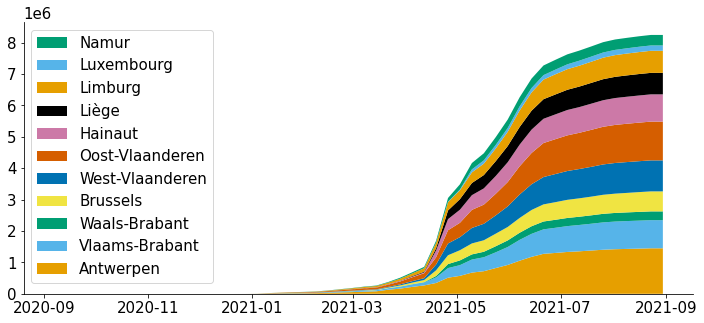

In [7]:
# Per province

dates_vacc = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='W-MON')
vaccs=[]
for date in dates_vacc:
    vacc = sciensano_spatial_first_dose(date).sum(axis=1)
    vaccs.append(vacc)
vaccs=np.array(vaccs).cumsum(axis=0)

fig,ax=plt.subplots(figsize=(12,5))
ax.grid(False)
labels = ['Antwerpen', 'Vlaams-Brabant', 'Waals-Brabant', 'Brussels', 'West-Vlaanderen', 'Oost-Vlaanderen',\
          'Hainaut', 'Liège', 'Limburg', 'Luxembourg', 'Namur']
ax.stackplot(dates_vacc, vaccs[:,0],\
             vaccs[:,1],\
             vaccs[:,2],\
             vaccs[:,3],\
             vaccs[:,4],\
             vaccs[:,5],\
             vaccs[:,6],\
             vaccs[:,7],\
             vaccs[:,8],\
             vaccs[:,9],\
             vaccs[:,10],\
             labels=labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

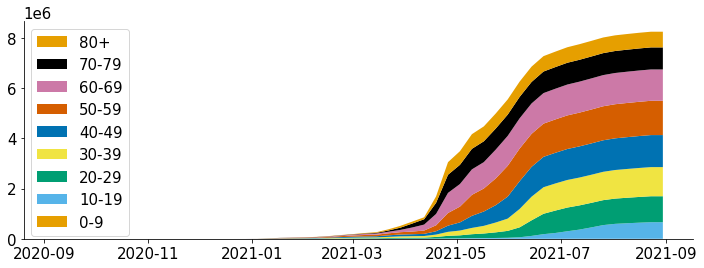

In [8]:
# Per age

vaccs = []
for date in dates_vacc:
    vacc = sciensano_spatial_first_dose(date).sum(axis=0)
    vaccs.append(vacc)
vaccs=np.array(vaccs).cumsum(axis=0)

fig,ax=plt.subplots(figsize=(12,4))
ax.grid(False)
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
ax.stackplot(dates_vacc, vaccs[:,0],\
             vaccs[:,1],\
             vaccs[:,2],\
             vaccs[:,3],\
             vaccs[:,4],\
             vaccs[:,5],\
             vaccs[:,6],\
             vaccs[:,7],\
             vaccs[:,8],\
             labels=labels)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left')

## Initialise model

In [12]:
# Model initial condition on August 27th

# Problem! These are the initial states for arrondissements.
# We are only interested in provinces for now, so we need to **aggregate**

init_states_name = 'arr_WAVE1_job-FULL_1000xPSO_20000xMCMC_arr_3-index-in-frac_2021-06-10_states_2020-08-27_full-manual-fix.json'
with open(f'../../data/interim/model_parameters/COVID19_SEIRD/calibrations/arr/{init_states_name}', 'r') as fp:
    initial_states = json.load(fp)

initial_states_prov = dict()
for key in initial_states:
    initial_states_prov[key] = np.zeros([11,9])
    initial_states_prov[key][0] = np.array(initial_states[key][0:3]).sum(axis=0) # 1000 Antwerp
    initial_states_prov[key][1] = np.array(initial_states[key][4:6]).sum(axis=0) # 20001 Vlaams-Brabant
    initial_states_prov[key][2] = np.array(initial_states[key][6]) # 20002 Waals-Brabant
    initial_states_prov[key][3] = np.array(initial_states[key][3]) # 21000 Brussel
    initial_states_prov[key][4] = np.array(initial_states[key][7:15]).sum(axis=0) # 30000 West-Vlaanderen
    initial_states_prov[key][5] = np.array(initial_states[key][15:21]).sum(axis=0) # 40000 Oost-Vlaanderen
    initial_states_prov[key][6] = np.array(initial_states[key][21:28]).sum(axis=0) # 50000 Hainaut
    initial_states_prov[key][7] = np.array(initial_states[key][28:33]).sum(axis=0) # 60000 Liege
    initial_states_prov[key][8] = np.array(initial_states[key][33:36]).sum(axis=0) # 70000 Limburg
    initial_states_prov[key][9] = np.array(initial_states[key][36:41]).sum(axis=0) # 80000 Luxembourg
    initial_states_prov[key][10] = np.array(initial_states[key][41:]).sum(axis=0) # 90000 

# Add empty entries for vaccination states
vacc_states = ['S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v']
for state in vacc_states:
    initial_states_prov[state]=np.zeros([11, 9])

In [27]:
vaccination_function(pd.Timestamp('2021-08-16'), {}, {}, initN)

KeyError: 'S'

In [21]:
model = models.COVID19_SEIRD_spatial_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE2_no_relaxation, \
                                                   'N_vacc': sciensano_spatial_first_dose, \
                                                   'alpha': VOC_function})

IndexError: list index out of range